* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
"""
    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
"""
nx = 9
ny = 6
height = 720
width = 1280

imgpoints = []
objpoints = []
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

images = glob.glob("camera_cal/calibration*.jpg")
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (width, height), None, None)

In [3]:
def undistort(img, mtx, dist):
    """
        Apply a distortion correction to raw images
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

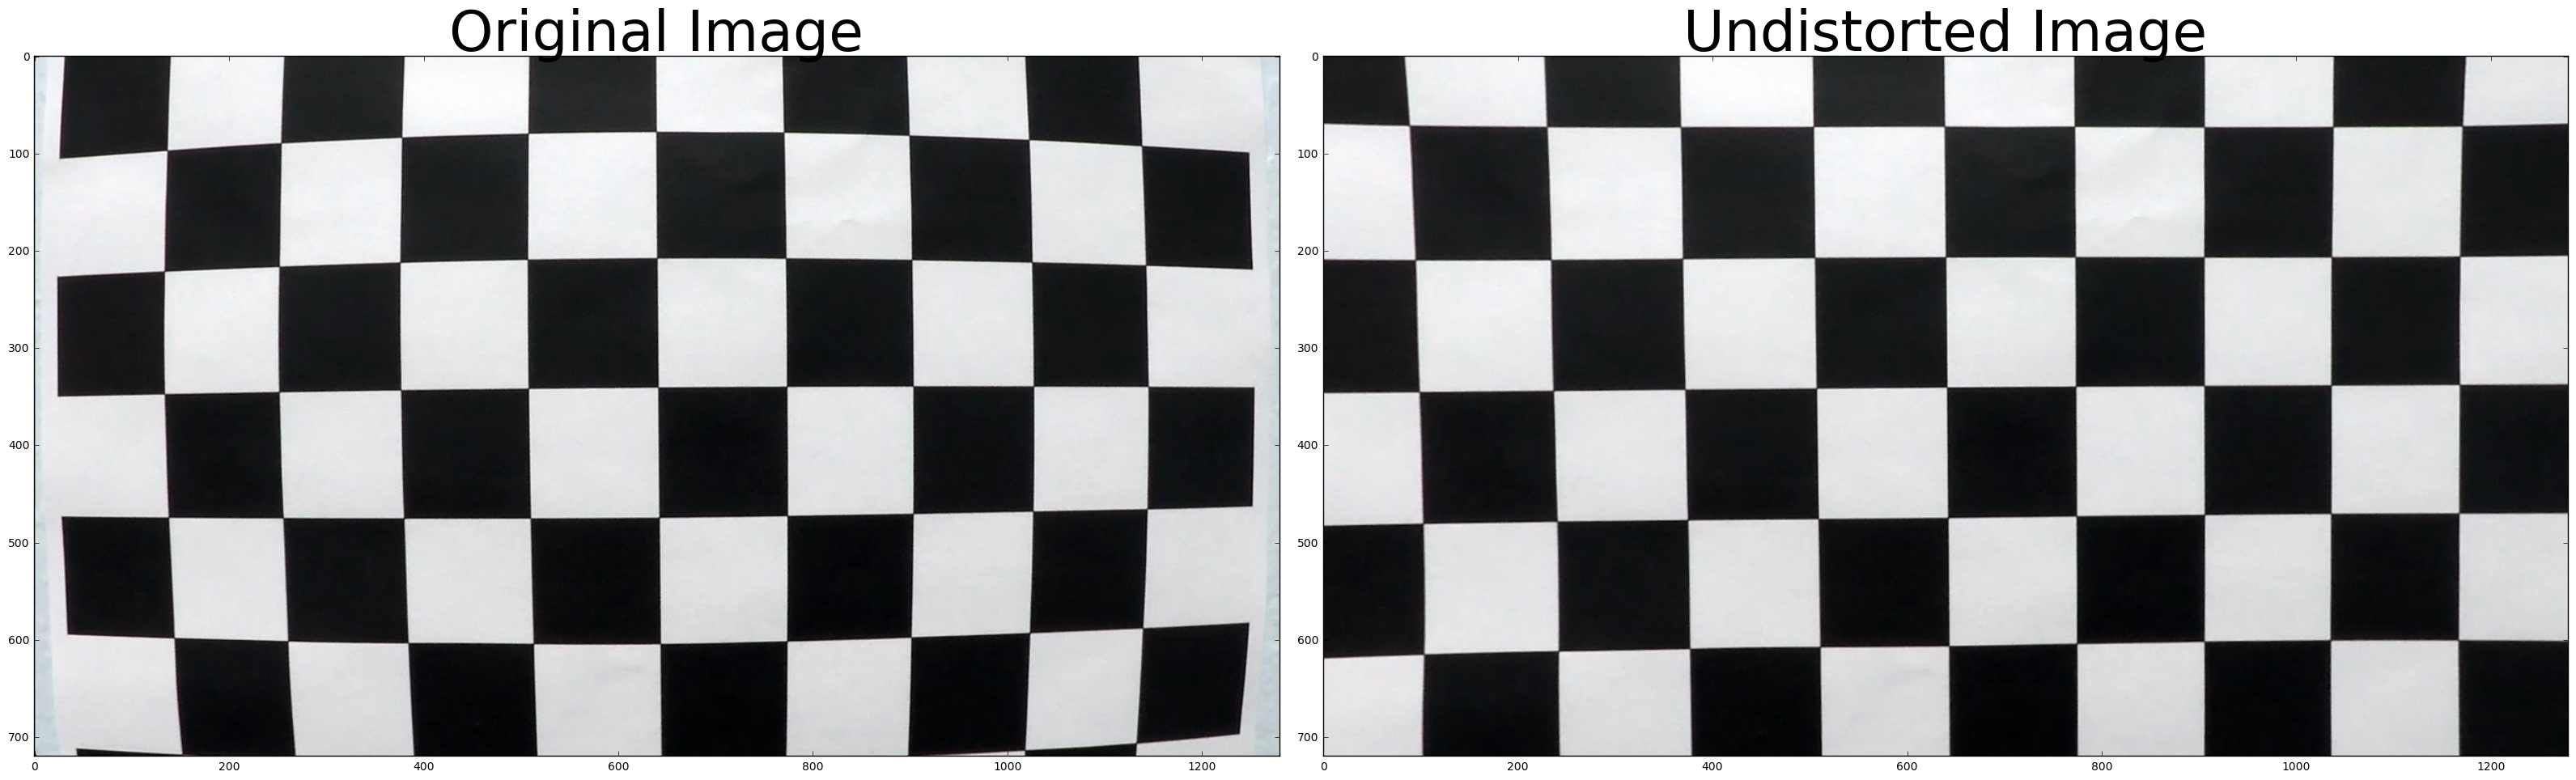

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
undist = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 32))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)

In [5]:
def threshold(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
    """
        Use color transforms, gradients, etc., to create a thresholded binary image.
    """    
    img_cpy = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img_cpy, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    binary_img = np.zeros((height, width))
    binary_img[(sxbinary == 1) | (s_binary == 1)] = 1
    return binary_img

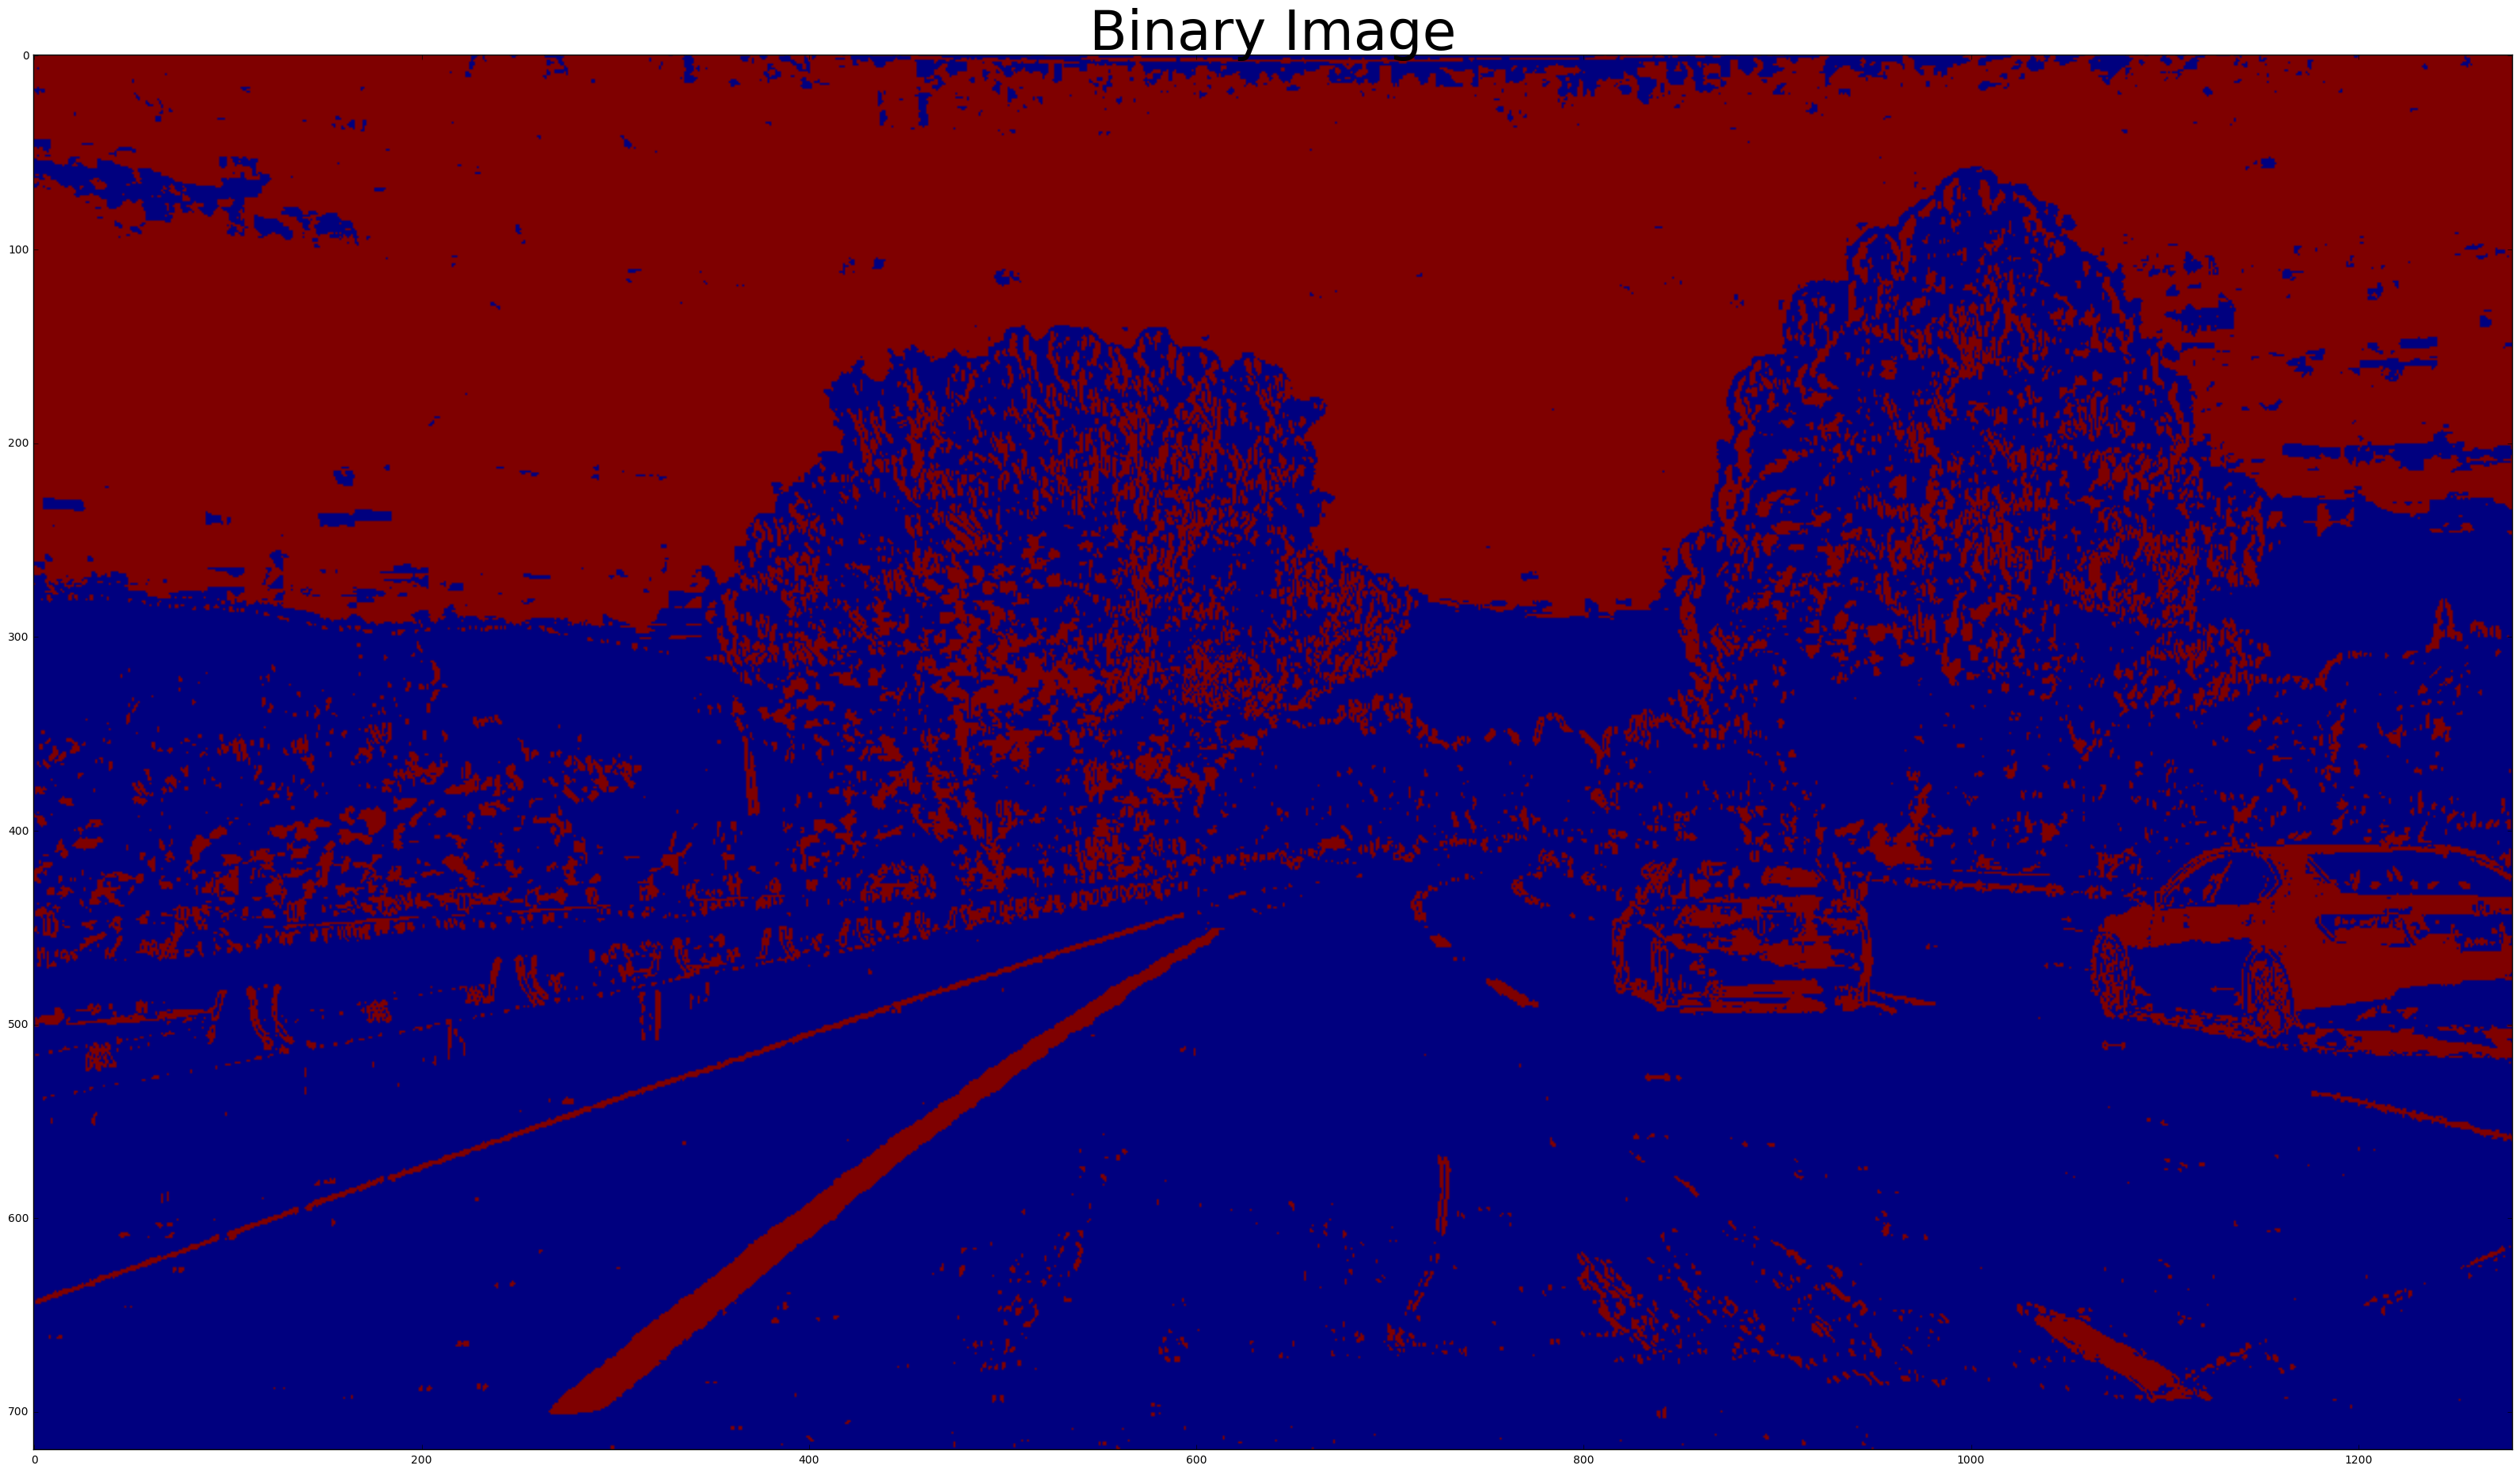

In [6]:
img = cv2.imread('test_images/test1.jpg')
undist = undistort(img, mtx, dist)
thd_img = threshold(undist)

f, ax = plt.subplots(1, 1, figsize=(32, 32))
f.tight_layout()
ax.imshow(thd_img)
ax.set_title('Binary Image', fontsize=50)

In [7]:
def perspective(img, M):
    """
        Apply a perspective transform to rectify binary image ("birds-eye view").
    """
    return cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_NEAREST)

In [8]:
# define 4 source points src = np.float32([[,],[,],[,],[,]])
src = np.float32([[1150, height], [690, 450], [595, 450], [220, height]])
# define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst = np.float32([[1020, height], [1000, 0], [300, 0], [300, height]])

# use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

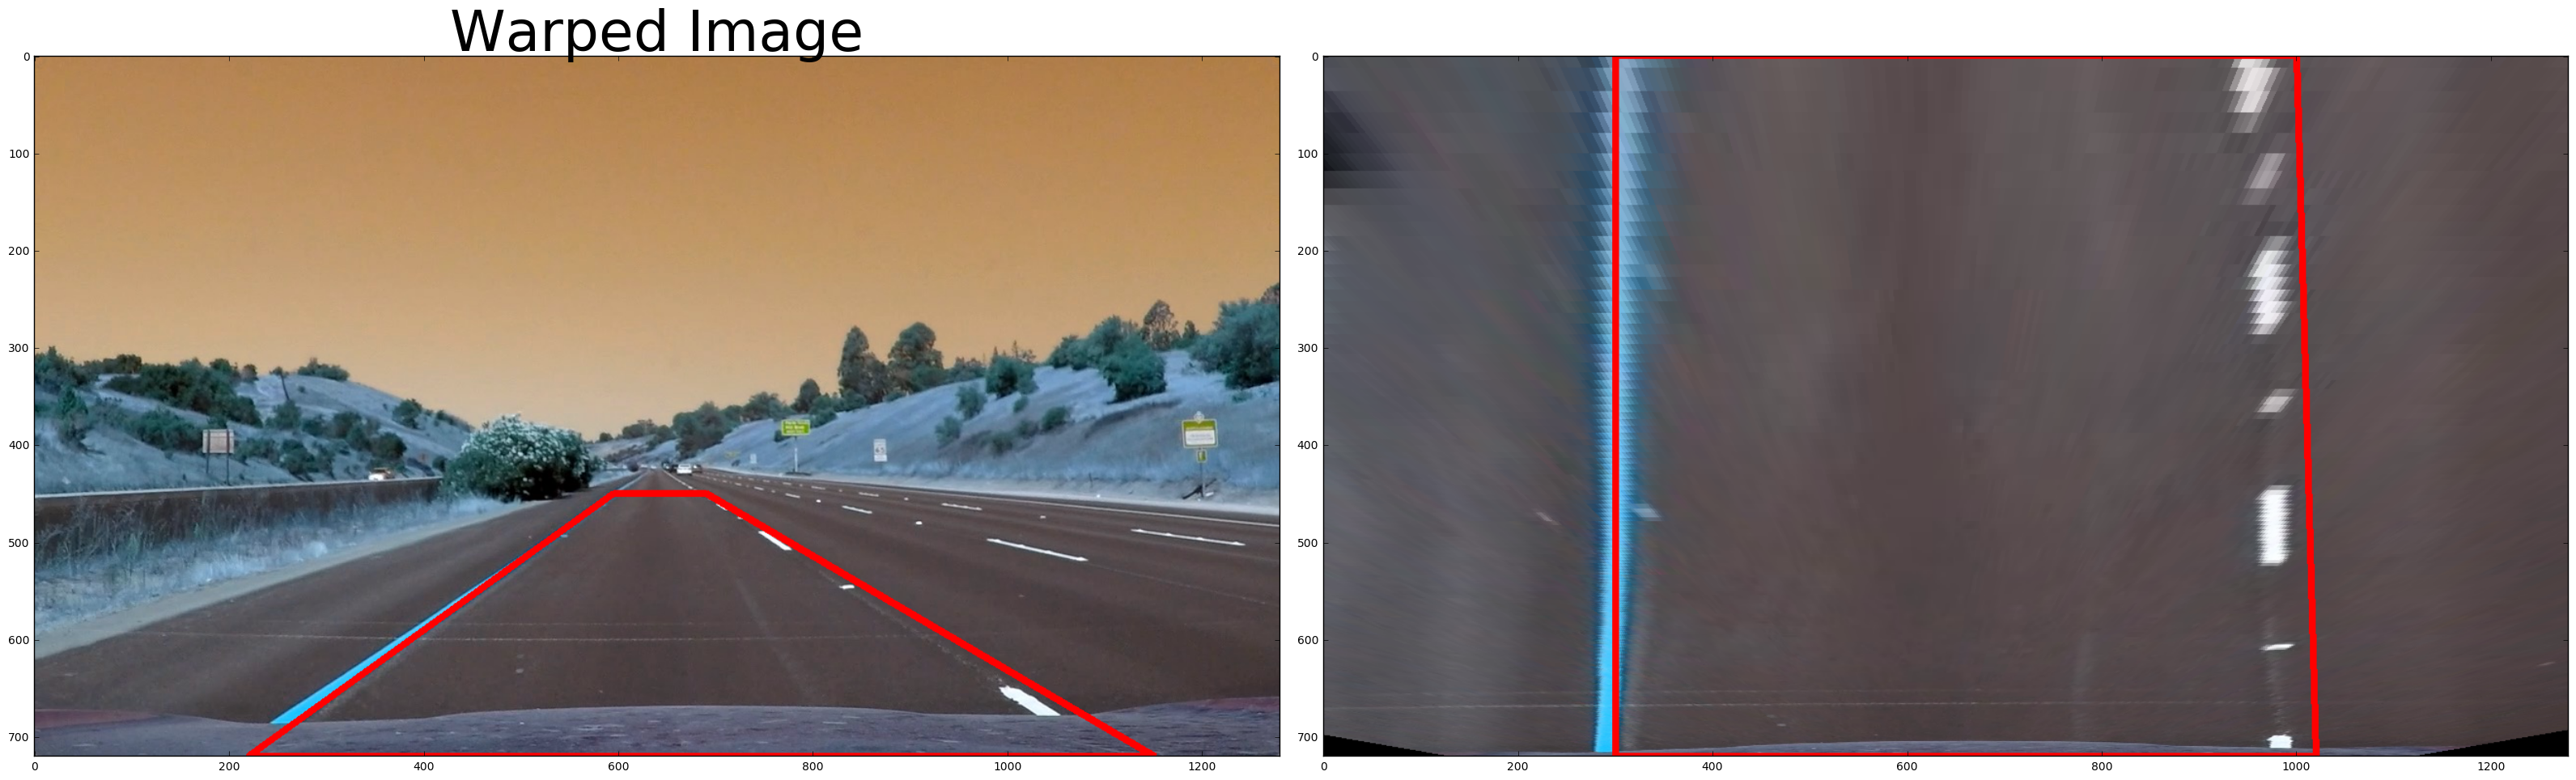

In [9]:
img = cv2.imread('test_images/straight_lines1.jpg')
undist = undistort(img, mtx, dist)
warped = perspective(undist, M)

cv2.polylines(img, np.int32([src]), 1, (255,0,0), thickness=5)
cv2.polylines(warped, np.int32([dst]), 1, (255,0,0), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 32))
f.tight_layout()
ax1.imshow(undist)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax1.set_title('Warped Image', fontsize=50)

In [10]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

In [11]:
def plot_window_centroids(img, window_centroids):
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((img,img,img)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    else:
        # If no window centers found, just display orginal road image
        output = np.array(cv2.merge((img,img,img)),np.uint8)
    return output, np.nonzero(l_points), np.nonzero(r_points)

In [12]:
def curvature(img, left, right):
    ploty = np.linspace(0, 719, num=720)
    lefty, leftx = left
    righty, rightx = right
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_pts = np.array([(y, x) for y,x in zip(left_fitx, ploty)], np.int32)
    right_pts = np.array([(y, x) for y,x in zip(right_fitx, ploty)], np.int32)
    #cv2.polylines(img, [left_pts], False, (255, 0, 0), thickness=10)
    #cv2.polylines(img, [right_pts], False, (255, 0, 0), thickness=10)

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(np.array(lefty)*ym_per_pix, np.array(leftx)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(righty)*ym_per_pix, np.array(rightx)*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad_real = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_real = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad_real, 'm', right_curverad_real, 'm')
    return img, left_pts, right_pts

In [13]:
def draw(img, pts_left, pts_right):
    # Create an image to draw the lines on
    img_zero = np.zeros_like(img).astype(np.uint8)

    # Draw the lane onto the warped blank image
    cv2.polylines(img_zero, [pts_left], False, (255, 0, 0), thickness=25)
    cv2.polylines(img_zero, [pts_right], False, (255, 0, 0), thickness=25)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(img_zero, Minv, (width, height))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

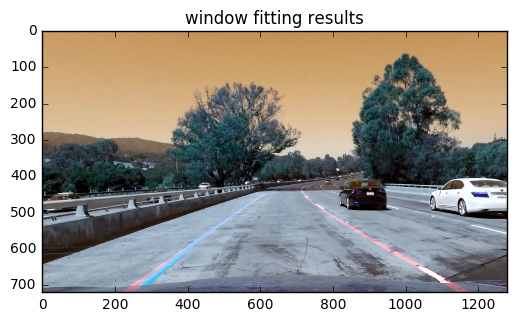

In [14]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

img = cv2.imread('test_images/test1.jpg')
undist = undistort(img, mtx, dist)
binary_img = threshold(undist)
warped = perspective(binary_img, M)

window_centroids = find_window_centroids(warped, window_width, window_height, margin)
output, left, right = plot_window_centroids(warped, window_centroids)
result_warped, left_pts, right_pts = curvature(undist, left, right)
result = draw(undist, left_pts, right_pts)

# Display the final results
plt.imshow(result)
plt.title('window fitting results')
plt.show()

In [15]:
def process_image(img):
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    undist = undistort(bgr_img, mtx, dist)
    rgb_undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    binary_img = threshold(undist)
    warped = perspective(binary_img, M)
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    output, left, right = plot_window_centroids(warped, window_centroids)
    result_warped, left_pts, right_pts = curvature(undist, left, right)
    result = draw(rgb_undist, left_pts, right_pts)
    return result

In [ ]:
f, ax = plt.subplots(len(images), 2, figsize=(64, 64))
f.tight_layout()

images = os.listdir('test_images/')
for idx in range(len(images)):
    filename = os.path.join('test_images', images[idx])
    img = cv2.imread(filename)
    result = process_image(img)
    ax[idx, 0].imshow(img)
    ax[idx, 1].imshow(result)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)